In [2]:
cd ATML-PA-2/DAN/

[Errno 2] No such file or directory: 'ATML-PA-2/DAN/'
/kaggle/working/ATML-PA-2/DAN


In [4]:
import importlib
import torch
import utils
import architecture
import train
import types
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier

In [5]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)
import seaborn as sns

def evaluate_ds(ds, model, device, domain_name=None, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    loader = torch.utils.data.DataLoader(ds, shuffle=False, batch_size=32)

    with torch.inference_mode():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            logits = model(X)  
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(Y.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()


    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)

    if domain_name:
        print(f"\n=== Evaluation for {domain_name} Domain ===")
    print(f"Accuracy: {acc*100:.2f}%")
    print("Confusion Matrix:\n")
    sns.heatmap(cm, cmap="Blues")
    plt.show()
    print("Classification Report:\n", report)

    return {
        'domain': domain_name,
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_true': y_true,
        'y_pred': y_pred
    }


In [8]:
import matplotlib.pyplot as plt

def analysis(source, target, config, cache_source=None, cache_target=None):
    
    model = resnet_classifier(num_classes=len(classes))

    if cache_source is None:
        source_ds = OfficeHomeDataset(root_dir, csv_file, source, transform)
        cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=64)

    if cache_target is None:
        target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)
        cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=64)

    truncated_model = _truncate_resnet_from(model, 'layer3')

    def _forward_impl(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        # return x, [x, f4]
        return x, [x]
    
    truncated_model.layer4.grad=False

    truncated_model.forward = types.MethodType(_forward_impl, truncated_model)

    cache_source_train, cache_source_test = torch.utils.data.random_split(cache_source, [0.8,0.2])
    torch.manual_seed(100)
    cache_target_train, cache_target_test = torch.utils.data.random_split(cache_target, [0.8,0.2])

    
    train_workflow(truncated_model, cache_source_train, cache_target_train, cache_target_test, config, device)

    def _forward_impl_2(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x
    truncated_model.forward = types.MethodType(_forward_impl_2, truncated_model)
    
    print(device)
    print("Evaluating on target domain test set")
    evaluate_ds(cache_target_test, truncated_model, device, target[0])

    print("Evaluating on source domain test set")
    evaluate_ds(cache_target_test, truncated_model, device, source)

    print("Evaluating on source domain train set")
    evaluate_ds(cache_source_train, truncated_model, device, source)

    latents_s, _ = get_features(truncated_model[:-1], cache_source_test, batchsize=32, device=device)
    latents_t, _ = get_features(truncated_model[:-1], cache_target_test, batchsize=32, device=device)

    if latents_s.dim() > 2:
        latents_s = latents_s.flatten(start_dim=1)
    if latents_t.dim() > 2:
        latents_t = latents_t.flatten(start_dim=1)

    latents = torch.cat([latents_s, latents_t], dim=0)
    domain_labels = torch.cat([
        torch.zeros(latents_s.shape[0], dtype=torch.long),   # 0 = source
        torch.ones(latents_t.shape[0], dtype=torch.long)     # 1 = target
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    tsne_plot(latents, domain_labels, classes=["Source", "Target"], ax=ax, fig=fig, perplexity=30)
    plt.title("t-SNE Domain Clustering: Source vs Target")
    plt.show()

In [ ]:
def get_domain_ds(domains, transform=None):
    return OfficeHomeDataset(root_dir, csv_file, domains, transform)

def combine_caches(caches):
    return torch.utils.data.ConcatDataset(caches)

def make_cache(domains, model, transforms=None, layer_name='layer3'):
    ds = OfficeHomeDataset(root_dir, csv_file, domains, transforms)
    return FeatureTensorDataset(ds, model, layer_name, device=device, batch_size=32)
    


In [ ]:
pairs = 

In [9]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)

In [10]:
model = resnet_classifier(num_classes=len(classes))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.6MB/s]


In [11]:
cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=32)
cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=32)

Precomputing up to layer3: 100%|██████████| 137/137 [00:41<00:00,  3.29it/s]


Training:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20

Train loss: 2.00535 | Supervised: 1.94962 | MK-MMD: 0.05573 | Source train acc: 19.58% | Target test acc=9.51%



Training:   5%|▌         | 1/20 [00:13<04:18, 13.63s/it]


Epoch 2/20

Train loss: 1.06320 | Supervised: 1.05964 | MK-MMD: 0.00356 | Source train acc: 43.73% | Target test acc=20.73%



Training:  10%|█         | 2/20 [00:26<03:59, 13.33s/it]


Epoch 3/20

Train loss: 0.75125 | Supervised: 0.75087 | MK-MMD: 0.00038 | Source train acc: 53.31% | Target test acc=22.57%



Training:  15%|█▌        | 3/20 [00:39<03:45, 13.24s/it]


Epoch 4/20

Train loss: 0.54762 | Supervised: 0.54737 | MK-MMD: 0.00025 | Source train acc: 69.53% | Target test acc=31.04%



Training:  20%|██        | 4/20 [00:53<03:31, 13.21s/it]


Epoch 5/20

Train loss: 0.41894 | Supervised: 0.41879 | MK-MMD: 0.00016 | Source train acc: 74.72% | Target test acc=31.84%



Training:  25%|██▌       | 5/20 [01:06<03:17, 13.18s/it]


Epoch 6/20

Train loss: 0.61541 | Supervised: 0.36197 | MK-MMD: 0.25344 | Source train acc: 79.75% | Target test acc=33.68%



Training:  30%|███       | 6/20 [01:19<03:04, 13.16s/it]


Epoch 7/20

Train loss: 0.29825 | Supervised: 0.29823 | MK-MMD: 0.00002 | Source train acc: 82.59% | Target test acc=34.71%



Training:  35%|███▌      | 7/20 [01:32<02:51, 13.16s/it]


Epoch 8/20

Train loss: 0.23730 | Supervised: 0.23729 | MK-MMD: 0.00001 | Source train acc: 84.26% | Target test acc=34.82%



Training:  40%|████      | 8/20 [01:45<02:37, 13.14s/it]


Epoch 9/20

Train loss: 0.20862 | Supervised: 0.20861 | MK-MMD: 0.00000 | Source train acc: 88.05% | Target test acc=33.79%



Training:  45%|████▌     | 9/20 [01:58<02:24, 13.14s/it]


Epoch 10/20

Train loss: 0.26898 | Supervised: 0.25162 | MK-MMD: 0.01736 | Source train acc: 74.80% | Target test acc=27.95%



Training:  50%|█████     | 10/20 [02:11<02:11, 13.14s/it]


Epoch 11/20

Train loss: 0.27030 | Supervised: 0.27029 | MK-MMD: 0.00001 | Source train acc: 81.10% | Target test acc=33.22%



Training:  55%|█████▌    | 11/20 [02:24<01:58, 13.14s/it]


Epoch 12/20

Train loss: 0.19769 | Supervised: 0.19769 | MK-MMD: 0.00001 | Source train acc: 88.63% | Target test acc=32.76%



Training:  60%|██████    | 12/20 [02:38<01:45, 13.13s/it]


Epoch 13/20

Train loss: 0.13555 | Supervised: 0.13554 | MK-MMD: 0.00001 | Source train acc: 91.04% | Target test acc=33.79%



Training:  65%|██████▌   | 13/20 [02:51<01:32, 13.15s/it]


Epoch 14/20

Train loss: 0.11878 | Supervised: 0.11877 | MK-MMD: 0.00001 | Source train acc: 94.15% | Target test acc=35.85%



Training:  70%|███████   | 14/20 [03:04<01:19, 13.18s/it]


Epoch 15/20

Train loss: 0.09201 | Supervised: 0.09200 | MK-MMD: 0.00001 | Source train acc: 94.72% | Target test acc=35.62%



Training:  75%|███████▌  | 15/20 [03:17<01:05, 13.18s/it]


Epoch 16/20

Train loss: 0.07669 | Supervised: 0.07668 | MK-MMD: 0.00001 | Source train acc: 96.26% | Target test acc=34.71%



Training:  80%|████████  | 16/20 [03:30<00:52, 13.17s/it]


Epoch 17/20

Train loss: 0.06587 | Supervised: 0.06587 | MK-MMD: 0.00000 | Source train acc: 96.44% | Target test acc=31.96%



Training:  85%|████████▌ | 17/20 [03:43<00:39, 13.16s/it]


Epoch 18/20

Train loss: 0.04766 | Supervised: 0.04766 | MK-MMD: 0.00001 | Source train acc: 97.87% | Target test acc=35.17%



Training:  90%|█████████ | 18/20 [03:57<00:26, 13.15s/it]


Epoch 19/20

Train loss: 0.03885 | Supervised: 0.03884 | MK-MMD: 0.00001 | Source train acc: 98.10% | Target test acc=35.62%



Training:  95%|█████████▌| 19/20 [04:10<00:13, 13.13s/it]


Epoch 20/20

Train loss: 0.03883 | Supervised: 0.03882 | MK-MMD: 0.00001 | Source train acc: 98.92% | Target test acc=35.05%



Training: 100%|██████████| 20/20 [04:23<00:00, 13.17s/it]

cuda
Evaluating on target domain test set



=== Evaluation for Clipart Domain ===
Accuracy: 35.05%
Confusion Matrix:



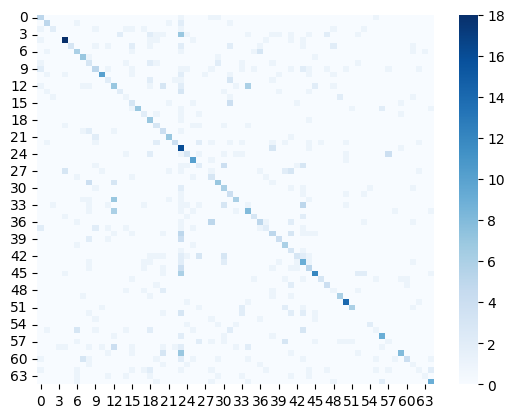

Classification Report:
               precision    recall  f1-score   support

           0     0.3333    0.5556    0.4167         9
           1     0.5000    0.5000    0.5000        10
           2     0.5000    0.2000    0.2857        10
           3     0.0000    0.0000    0.0000        22
           4     0.6923    0.7200    0.7059        25
           5     1.0000    0.1765    0.3000        17
           6     0.3529    0.4000    0.3750        15
           7     0.5000    0.7000    0.5833        10
           8     0.1364    0.2308    0.1714        13
           9     0.3125    0.2273    0.2632        22
          10     0.7692    0.5000    0.6061        20
          11     0.2222    0.2000    0.2105        10
          12     0.2333    0.2692    0.2500        26
          13     0.5000    0.2222    0.3077         9
          14     0.1250    0.1667    0.1429         6
          15     0.1875    0.2727    0.2222        11
          16     1.0000    0.5385    0.7000        13
   

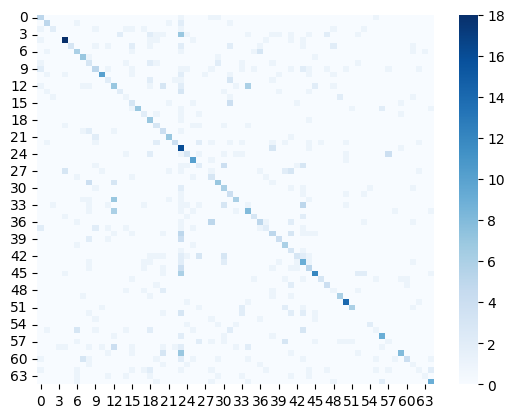

Classification Report:
               precision    recall  f1-score   support

           0     0.3333    0.5556    0.4167         9
           1     0.5000    0.5000    0.5000        10
           2     0.5000    0.2000    0.2857        10
           3     0.0000    0.0000    0.0000        22
           4     0.6923    0.7200    0.7059        25
           5     1.0000    0.1765    0.3000        17
           6     0.3529    0.4000    0.3750        15
           7     0.5000    0.7000    0.5833        10
           8     0.1364    0.2308    0.1714        13
           9     0.3125    0.2273    0.2632        22
          10     0.7692    0.5000    0.6061        20
          11     0.2222    0.2000    0.2105        10
          12     0.2333    0.2692    0.2500        26
          13     0.5000    0.2222    0.3077         9
          14     0.1250    0.1667    0.1429         6
          15     0.1875    0.2727    0.2222        11
          16     1.0000    0.5385    0.7000        13
   

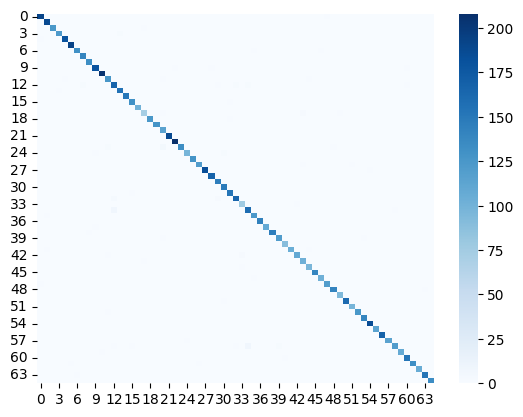

Classification Report:
               precision    recall  f1-score   support

           0     0.9896    0.9948    0.9922       192
           1     0.9895    1.0000    0.9947       188
           2     1.0000    0.9921    0.9960       126
           3     0.9919    0.9839    0.9879       124
           4     0.9945    0.9945    0.9945       181
           5     0.9948    1.0000    0.9974       193
           6     0.9924    0.9848    0.9886       132
           7     0.9859    1.0000    0.9929       140
           8     0.9925    1.0000    0.9963       133
           9     0.9890    0.9836    0.9863       183
          10     0.9951    1.0000    0.9976       205
          11     0.9692    0.9767    0.9730       129
          12     0.9274    0.9540    0.9405       174
          13     0.9873    0.9936    0.9904       156
          14     1.0000    1.0000    1.0000       151
          15     0.9848    0.9924    0.9886       131
          16     1.0000    1.0000    1.0000       101
   

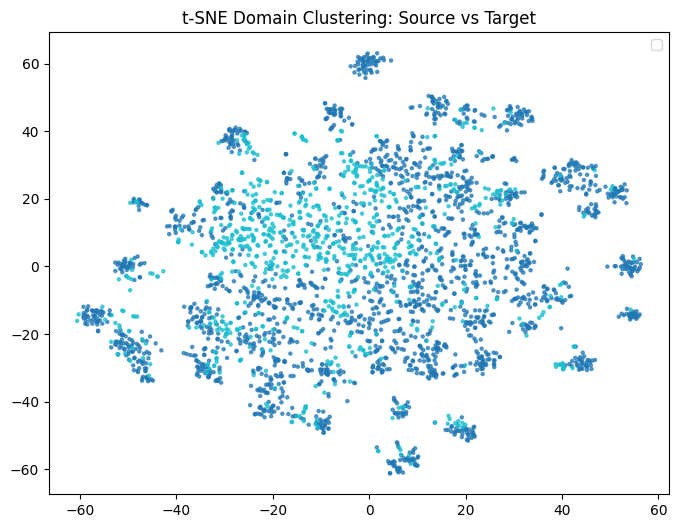

In [12]:
config = {'epochs': 20, 
          'lr':1e-3, 
          'batch_size':32, 
          'weight_decay':1e-4, 
          'sigmas':[2e-16,2e-12,2e-8,2e-4,2e+0,2e+4,2e+8,2e+12,2e+16], 
          'scale':48000
          }
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=cache_target)

Training:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1/15

Train loss: 0.81331 | Supervised: 0.81303 | MK-MMD: 0.00028 | Source train acc: 76.34% | Target test acc=40.32%



Training:   7%|▋         | 1/15 [00:12<02:56, 12.57s/it]


Epoch 2/15

Train loss: 0.31826 | Supervised: 0.31822 | MK-MMD: 0.00005 | Source train acc: 84.63% | Target test acc=43.07%



Training:  13%|█▎        | 2/15 [00:24<02:41, 12.40s/it]


Epoch 3/15

Train loss: 0.19885 | Supervised: 0.19880 | MK-MMD: 0.00005 | Source train acc: 90.12% | Target test acc=47.54%



Training:  20%|██        | 3/15 [00:37<02:29, 12.42s/it]


Epoch 4/15

Train loss: 0.13776 | Supervised: 0.13768 | MK-MMD: 0.00007 | Source train acc: 92.71% | Target test acc=45.48%



Training:  27%|██▋       | 4/15 [00:49<02:16, 12.41s/it]


Epoch 5/15

Train loss: 0.11023 | Supervised: 0.11022 | MK-MMD: 0.00001 | Source train acc: 95.01% | Target test acc=45.48%



Training:  33%|███▎      | 5/15 [01:01<02:03, 12.35s/it]


Epoch 6/15

Train loss: 0.07250 | Supervised: 0.07248 | MK-MMD: 0.00003 | Source train acc: 96.63% | Target test acc=47.19%



Training:  40%|████      | 6/15 [01:14<01:52, 12.46s/it]


Epoch 7/15

Train loss: 0.05669 | Supervised: 0.05663 | MK-MMD: 0.00006 | Source train acc: 97.66% | Target test acc=47.08%



Training:  47%|████▋     | 7/15 [01:26<01:39, 12.38s/it]


Epoch 8/15

Train loss: 0.03613 | Supervised: 0.03613 | MK-MMD: 0.00001 | Source train acc: 98.01% | Target test acc=46.85%



Training:  53%|█████▎    | 8/15 [01:39<01:26, 12.32s/it]


Epoch 9/15

Train loss: 0.03223 | Supervised: 0.03206 | MK-MMD: 0.00017 | Source train acc: 98.58% | Target test acc=48.22%



Training:  60%|██████    | 9/15 [01:51<01:13, 12.30s/it]


Epoch 10/15

Train loss: 0.02180 | Supervised: 0.02177 | MK-MMD: 0.00003 | Source train acc: 98.98% | Target test acc=47.42%



Training:  67%|██████▋   | 10/15 [02:03<01:01, 12.30s/it]


Epoch 11/15

Train loss: 0.02337 | Supervised: 0.02233 | MK-MMD: 0.00104 | Source train acc: 99.01% | Target test acc=47.08%



Training:  73%|███████▎  | 11/15 [02:15<00:48, 12.21s/it]


Epoch 12/15

Train loss: 0.01802 | Supervised: 0.01794 | MK-MMD: 0.00008 | Source train acc: 99.50% | Target test acc=46.85%



Training:  80%|████████  | 12/15 [02:27<00:36, 12.21s/it]


Epoch 13/15

Train loss: 0.01478 | Supervised: 0.01451 | MK-MMD: 0.00026 | Source train acc: 99.55% | Target test acc=47.77%



Training:  87%|████████▋ | 13/15 [02:40<00:24, 12.26s/it]


Epoch 14/15

Train loss: 0.00812 | Supervised: 0.00809 | MK-MMD: 0.00003 | Source train acc: 99.63% | Target test acc=47.31%



Training:  93%|█████████▎| 14/15 [02:52<00:12, 12.32s/it]


Epoch 15/15

Train loss: 0.01275 | Supervised: 0.01209 | MK-MMD: 0.00066 | Source train acc: 99.39% | Target test acc=48.11%



Training: 100%|██████████| 15/15 [03:04<00:00, 12.32s/it]

cuda
Evaluating on target domain test set



=== Evaluation for Clipart Domain ===
Accuracy: 48.11%
Confusion Matrix:



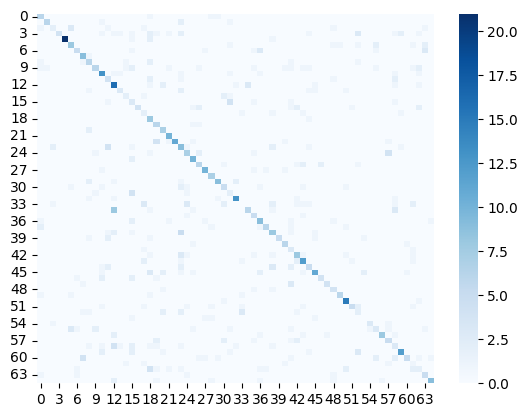

Classification Report:
               precision    recall  f1-score   support

           0     0.4286    0.6667    0.5217         9
           1     0.8571    0.6000    0.7059        10
           2     0.3333    0.2000    0.2500        10
           3     1.0000    0.1818    0.3077        22
           4     1.0000    0.8400    0.9130        25
           5     0.5000    0.4706    0.4848        17
           6     0.5556    0.3333    0.4167        15
           7     0.5625    0.9000    0.6923        10
           8     0.3750    0.4615    0.4138        13
           9     0.6000    0.2727    0.3750        22
          10     0.5200    0.6500    0.5778        20
          11     0.2667    0.4000    0.3200        10
          12     0.4211    0.6154    0.5000        26
          13     0.5000    0.3333    0.4000         9
          14     0.4000    0.3333    0.3636         6
          15     0.1200    0.2727    0.1667        11
          16     1.0000    0.3077    0.4706        13
   

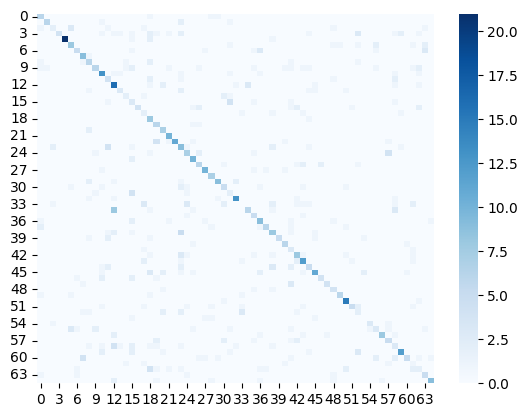

Classification Report:
               precision    recall  f1-score   support

           0     0.4286    0.6667    0.5217         9
           1     0.8571    0.6000    0.7059        10
           2     0.3333    0.2000    0.2500        10
           3     1.0000    0.1818    0.3077        22
           4     1.0000    0.8400    0.9130        25
           5     0.5000    0.4706    0.4848        17
           6     0.5556    0.3333    0.4167        15
           7     0.5625    0.9000    0.6923        10
           8     0.3750    0.4615    0.4138        13
           9     0.6000    0.2727    0.3750        22
          10     0.5200    0.6500    0.5778        20
          11     0.2667    0.4000    0.3200        10
          12     0.4211    0.6154    0.5000        26
          13     0.5000    0.3333    0.4000         9
          14     0.4000    0.3333    0.3636         6
          15     0.1200    0.2727    0.1667        11
          16     1.0000    0.3077    0.4706        13
   

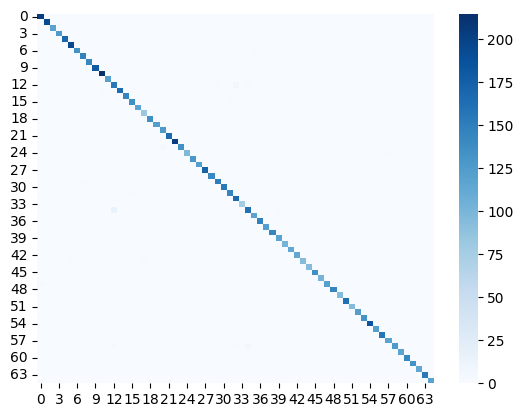

Classification Report:
               precision    recall  f1-score   support

           0     0.9807    1.0000    0.9902       203
           1     1.0000    1.0000    1.0000       194
           2     1.0000    1.0000    1.0000       119
           3     1.0000    1.0000    1.0000       126
           4     1.0000    1.0000    1.0000       169
           5     0.9949    1.0000    0.9974       195
           6     1.0000    0.9925    0.9963       134
           7     0.9932    1.0000    0.9966       147
           8     1.0000    1.0000    1.0000       143
           9     1.0000    1.0000    1.0000       181
          10     0.9954    1.0000    0.9977       215
          11     1.0000    1.0000    1.0000       121
          12     0.8908    0.9394    0.9145       165
          13     1.0000    0.9940    0.9970       166
          14     1.0000    1.0000    1.0000       145
          15     0.9927    0.9927    0.9927       137
          16     1.0000    1.0000    1.0000       118
   

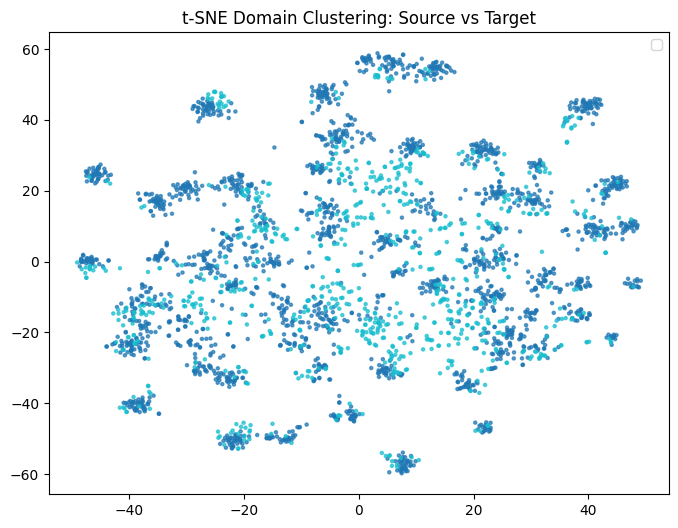

In [132]:
config = {'epochs': 15, 
          'lr':1e-3, 
          'batch_size':128, 
          'weight_decay':1e-4, 
          'sigmas':[2e-16,2e-12,2e-8,2e-4,2e+0,2e+4,2e+8,2e+12,2e+16], 
          'scale':64
          }
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=cache_target)

Training:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/12

Train loss: 0.83097 | Supervised: 0.82923 | MK-MMD: 0.00174 | Source train acc: 79.39% | Target test acc=44.22%



Training:   8%|▊         | 1/12 [00:14<02:38, 14.37s/it]


Epoch 2/12

Train loss: 0.34879 | Supervised: 0.34871 | MK-MMD: 0.00008 | Source train acc: 86.93% | Target test acc=45.48%



Training:  17%|█▋        | 2/12 [00:28<02:20, 14.09s/it]


Epoch 3/12

Train loss: 0.22375 | Supervised: 0.22361 | MK-MMD: 0.00014 | Source train acc: 89.80% | Target test acc=46.62%



Training:  25%|██▌       | 3/12 [00:42<02:06, 14.07s/it]


Epoch 4/12

Train loss: 0.17115 | Supervised: 0.17114 | MK-MMD: 0.00001 | Source train acc: 92.63% | Target test acc=46.62%



Training:  33%|███▎      | 4/12 [00:56<01:51, 13.98s/it]


Epoch 5/12

Train loss: 0.12340 | Supervised: 0.12339 | MK-MMD: 0.00001 | Source train acc: 95.11% | Target test acc=45.70%



Training:  42%|████▏     | 5/12 [01:10<01:39, 14.17s/it]


Epoch 6/12

Train loss: 0.10234 | Supervised: 0.10221 | MK-MMD: 0.00013 | Source train acc: 96.52% | Target test acc=48.11%



Training:  50%|█████     | 6/12 [01:24<01:24, 14.10s/it]


Epoch 7/12

Train loss: 0.07603 | Supervised: 0.07518 | MK-MMD: 0.00085 | Source train acc: 97.19% | Target test acc=48.68%



Training:  58%|█████▊    | 7/12 [01:38<01:10, 14.10s/it]


Epoch 8/12

Train loss: 0.05706 | Supervised: 0.05651 | MK-MMD: 0.00055 | Source train acc: 98.06% | Target test acc=45.48%



Training:  67%|██████▋   | 8/12 [01:52<00:56, 14.05s/it]


Epoch 9/12

Train loss: 0.04177 | Supervised: 0.04135 | MK-MMD: 0.00042 | Source train acc: 98.68% | Target test acc=47.54%



Training:  75%|███████▌  | 9/12 [02:06<00:42, 14.05s/it]


Epoch 10/12

Train loss: 0.04378 | Supervised: 0.03999 | MK-MMD: 0.00379 | Source train acc: 98.59% | Target test acc=45.36%



Training:  83%|████████▎ | 10/12 [02:20<00:27, 13.97s/it]


Epoch 11/12

Train loss: 0.12343 | Supervised: 0.03779 | MK-MMD: 0.08564 | Source train acc: 99.08% | Target test acc=46.05%



Training:  92%|█████████▏| 11/12 [02:34<00:13, 13.90s/it]


Epoch 12/12

Train loss: 0.03091 | Supervised: 0.03032 | MK-MMD: 0.00059 | Source train acc: 99.15% | Target test acc=44.67%



Training: 100%|██████████| 12/12 [02:48<00:00, 14.04s/it]

cuda
Evaluating on target domain test set



=== Evaluation for Clipart Domain ===
Accuracy: 44.67%
Confusion Matrix:



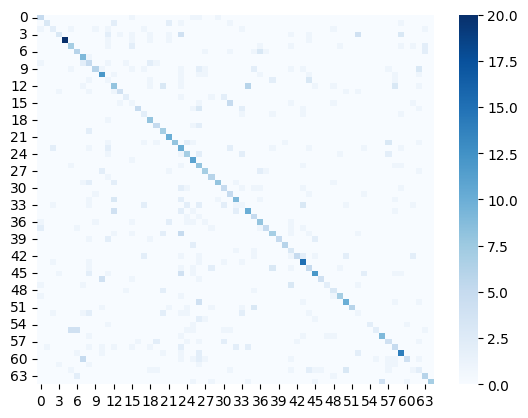

Classification Report:
               precision    recall  f1-score   support

           0     0.4167    0.5556    0.4762         9
           1     0.7500    0.3000    0.4286        10
           2     0.2857    0.2000    0.2353        10
           3     0.5000    0.1364    0.2143        22
           4     1.0000    0.8000    0.8889        25
           5     0.4667    0.4118    0.4375        17
           6     0.4286    0.4000    0.4138        15
           7     0.4500    0.9000    0.6000        10
           8     0.2000    0.3846    0.2632        13
           9     0.6667    0.2727    0.3871        22
          10     0.5455    0.6000    0.5714        20
          11     0.0588    0.1000    0.0741        10
          12     0.3478    0.3077    0.3265        26
          13     0.6667    0.4444    0.5333         9
          14     0.5000    0.3333    0.4000         6
          15     0.0833    0.0909    0.0870        11
          16     0.8333    0.3846    0.5263        13
   

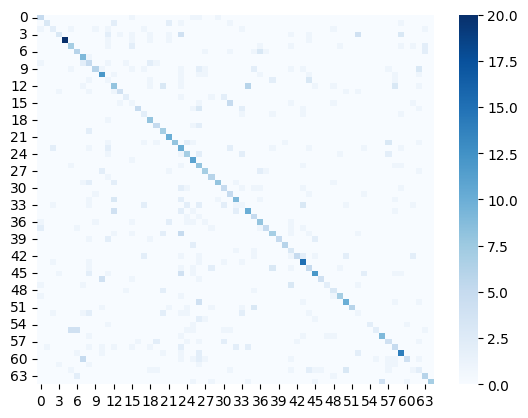

Classification Report:
               precision    recall  f1-score   support

           0     0.4167    0.5556    0.4762         9
           1     0.7500    0.3000    0.4286        10
           2     0.2857    0.2000    0.2353        10
           3     0.5000    0.1364    0.2143        22
           4     1.0000    0.8000    0.8889        25
           5     0.4667    0.4118    0.4375        17
           6     0.4286    0.4000    0.4138        15
           7     0.4500    0.9000    0.6000        10
           8     0.2000    0.3846    0.2632        13
           9     0.6667    0.2727    0.3871        22
          10     0.5455    0.6000    0.5714        20
          11     0.0588    0.1000    0.0741        10
          12     0.3478    0.3077    0.3265        26
          13     0.6667    0.4444    0.5333         9
          14     0.5000    0.3333    0.4000         6
          15     0.0833    0.0909    0.0870        11
          16     0.8333    0.3846    0.5263        13
   

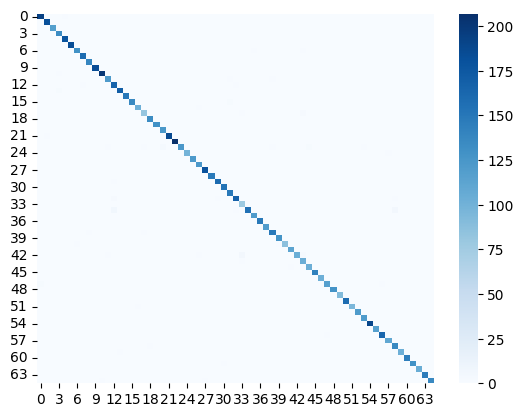

Classification Report:
               precision    recall  f1-score   support

           0     0.9897    0.9948    0.9923       194
           1     0.9945    1.0000    0.9973       182
           2     1.0000    1.0000    1.0000       118
           3     0.9781    1.0000    0.9889       134
           4     0.9944    1.0000    0.9972       178
           5     1.0000    1.0000    1.0000       184
           6     0.9923    0.9847    0.9885       131
           7     0.9938    1.0000    0.9969       159
           8     0.9929    1.0000    0.9964       139
           9     1.0000    1.0000    1.0000       185
          10     0.9950    0.9950    0.9950       202
          11     0.9839    0.9839    0.9839       124
          12     0.9375    0.9880    0.9621       167
          13     0.9942    0.9884    0.9913       172
          14     1.0000    1.0000    1.0000       150
          15     1.0000    0.9855    0.9927       138
          16     0.9903    0.9903    0.9903       103
   

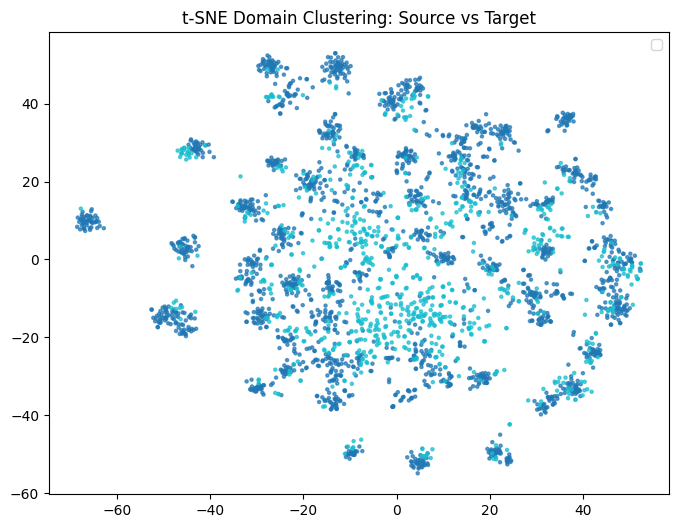

In [134]:
#this model finetuned only the final layer after observing severe overfitting on source train set.
config = {'epochs': 12, 
          'lr':1e-3, 
          'batch_size':32, 
          'weight_decay':1e-4, 
          'sigmas':[2e-16,2e-12,2e-8,2e-4,2e+0,2e+4,2e+8,2e+12,2e+16], 
          'scale':128
          }
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=cache_target)

Training:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/12

Train loss: 0.97923 | Supervised: 0.97892 | MK-MMD: 0.00031 | Source train acc: 69.16% | Target test acc=39.86%



Training:   8%|▊         | 1/12 [00:11<02:03, 11.22s/it]


Epoch 2/12

Train loss: 0.40089 | Supervised: 0.40084 | MK-MMD: 0.00005 | Source train acc: 81.40% | Target test acc=43.30%



Training:  17%|█▋        | 2/12 [00:22<01:50, 11.00s/it]


Epoch 3/12

Train loss: 0.26205 | Supervised: 0.26203 | MK-MMD: 0.00003 | Source train acc: 85.35% | Target test acc=42.50%



Training:  25%|██▌       | 3/12 [00:32<01:38, 10.90s/it]


Epoch 4/12

Train loss: 0.18401 | Supervised: 0.18397 | MK-MMD: 0.00004 | Source train acc: 89.15% | Target test acc=46.96%



Training:  33%|███▎      | 4/12 [00:43<01:26, 10.86s/it]


Epoch 5/12

Train loss: 0.14468 | Supervised: 0.14465 | MK-MMD: 0.00003 | Source train acc: 92.20% | Target test acc=45.59%



Training:  42%|████▏     | 5/12 [00:54<01:15, 10.85s/it]


Epoch 6/12

Train loss: 0.11295 | Supervised: 0.11280 | MK-MMD: 0.00015 | Source train acc: 94.15% | Target test acc=46.28%



Training:  50%|█████     | 6/12 [01:05<01:04, 10.82s/it]


Epoch 7/12

Train loss: 0.09304 | Supervised: 0.09300 | MK-MMD: 0.00004 | Source train acc: 95.41% | Target test acc=46.51%



Training:  58%|█████▊    | 7/12 [01:15<00:53, 10.77s/it]


Epoch 8/12

Train loss: 0.06612 | Supervised: 0.06606 | MK-MMD: 0.00006 | Source train acc: 96.32% | Target test acc=48.22%



Training:  67%|██████▋   | 8/12 [01:26<00:43, 10.81s/it]


Epoch 9/12

Train loss: 0.05898 | Supervised: 0.05859 | MK-MMD: 0.00039 | Source train acc: 97.38% | Target test acc=47.19%



Training:  75%|███████▌  | 9/12 [01:37<00:32, 10.77s/it]


Epoch 10/12

Train loss: 0.04798 | Supervised: 0.04772 | MK-MMD: 0.00026 | Source train acc: 97.39% | Target test acc=46.51%



Training:  83%|████████▎ | 10/12 [01:48<00:21, 10.76s/it]


Epoch 11/12

Train loss: 0.03924 | Supervised: 0.03905 | MK-MMD: 0.00019 | Source train acc: 98.55% | Target test acc=46.39%



Training:  92%|█████████▏| 11/12 [01:58<00:10, 10.75s/it]


Epoch 12/12

Train loss: 0.03071 | Supervised: 0.02751 | MK-MMD: 0.00320 | Source train acc: 98.69% | Target test acc=44.44%



Training: 100%|██████████| 12/12 [02:09<00:00, 10.80s/it]

cuda
Evaluating on target domain test set



=== Evaluation for Clipart Domain ===
Accuracy: 44.44%
Confusion Matrix:



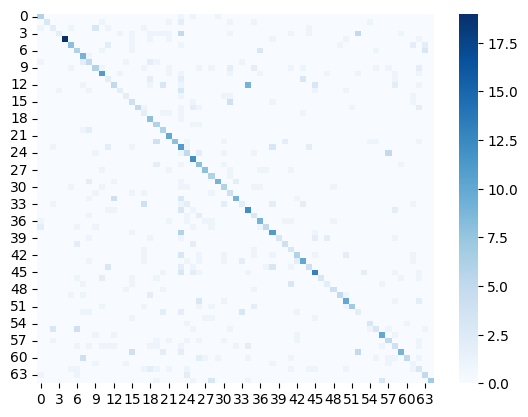

Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.6667    0.5714         9
           1     1.0000    0.3000    0.4615        10
           2     0.2500    0.2000    0.2222        10
           3     0.6667    0.0909    0.1600        22
           4     1.0000    0.7600    0.8636        25
           5     0.6154    0.4706    0.5333        17
           6     0.3529    0.4000    0.3750        15
           7     0.4500    0.9000    0.6000        10
           8     0.2941    0.3846    0.3333        13
           9     0.4286    0.2727    0.3333        22
          10     0.5500    0.5500    0.5500        20
          11     0.1667    0.2000    0.1818        10
          12     0.3846    0.1923    0.2564        26
          13     0.5000    0.2222    0.3077         9
          14     0.4000    0.3333    0.3636         6
          15     0.2222    0.3636    0.2759        11
          16     1.0000    0.3846    0.5556        13
   

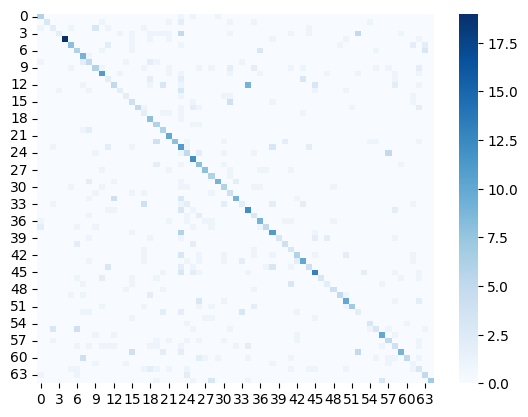

Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.6667    0.5714         9
           1     1.0000    0.3000    0.4615        10
           2     0.2500    0.2000    0.2222        10
           3     0.6667    0.0909    0.1600        22
           4     1.0000    0.7600    0.8636        25
           5     0.6154    0.4706    0.5333        17
           6     0.3529    0.4000    0.3750        15
           7     0.4500    0.9000    0.6000        10
           8     0.2941    0.3846    0.3333        13
           9     0.4286    0.2727    0.3333        22
          10     0.5500    0.5500    0.5500        20
          11     0.1667    0.2000    0.1818        10
          12     0.3846    0.1923    0.2564        26
          13     0.5000    0.2222    0.3077         9
          14     0.4000    0.3333    0.3636         6
          15     0.2222    0.3636    0.2759        11
          16     1.0000    0.3846    0.5556        13
   

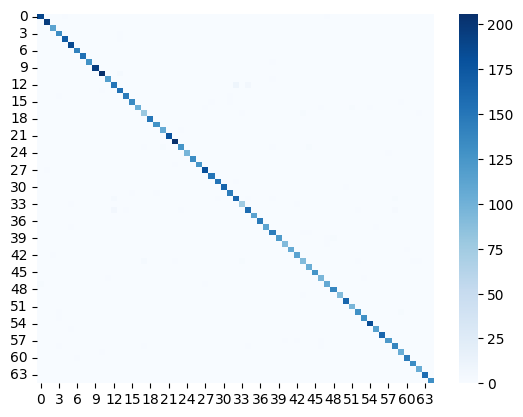

Classification Report:
               precision    recall  f1-score   support

           0     0.9895    0.9895    0.9895       190
           1     0.9949    1.0000    0.9975       196
           2     0.9912    1.0000    0.9956       113
           3     0.9706    0.9925    0.9814       133
           4     0.9942    0.9942    0.9942       172
           5     0.9841    1.0000    0.9920       186
           6     0.9930    1.0000    0.9965       141
           7     1.0000    1.0000    1.0000       155
           8     1.0000    0.9922    0.9961       129
           9     1.0000    1.0000    1.0000       195
          10     0.9904    0.9810    0.9856       210
          11     0.9916    0.9916    0.9916       119
          12     0.9379    0.9096    0.9235       166
          13     0.9625    0.9935    0.9778       155
          14     0.9933    0.9867    0.9900       150
          15     0.9926    0.9783    0.9854       138
          16     1.0000    0.9537    0.9763       108
   

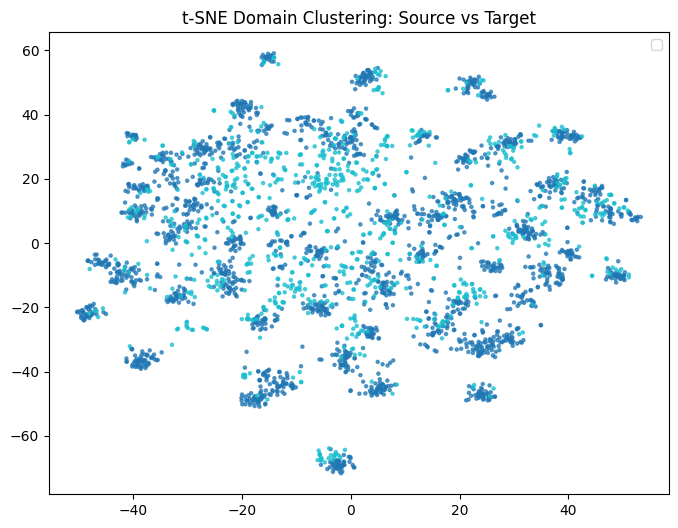

: 

In [ ]:
config = {'epochs': 12, 
          'lr':6e-4, 
          'batch_size': 256, 
          'weight_decay':1e-3, #increase regularization 
          'sigmas':[2e-16,2e-12,2e-8,2e-4,2e+0,2e+4,2e+8,2e+12,2e+16], 
          'scale':128
          }
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=cache_target)